# 🚀 SAIR PyTorch Mastery - Lecture 2: Professional Data Pipelines with PyTorch

**Course:** Ultimate Applied Deep Learning with PyTorch  
**Module:** Advanced PyTorch & Production ML  
**Instructor:** Mohammed Awad Ahmed (Silva)  
**SAIR Community:** Building Sudan's AI Future 🇸🇩

---

## 📘 How to Use This Notebook

This is a **standalone, self-teaching lecture notebook** designed to replace traditional video lectures. Here's how to get the most from it:

**How to Study:**
1. **Read all markdown cells carefully** - they contain explanations, mental models, and reasoning
2. **Run code cells sequentially** - don't skip ahead as each builds on the previous
3. **Pause at "Stop & Think" prompts** - make predictions before running the next cell
4. **Experiment with the code** - change parameters and see what happens

**Time Commitment:** ~2-3 hours for complete understanding

**Learning Outcomes:** After completing this notebook, you will be able to:
1. Build efficient PyTorch datasets for any data type
2. Optimize DataLoader performance for maximum GPU utilization
3. Create professional data augmentation pipelines
4. Handle large datasets with streaming and memory mapping
5. Build multi-modal data pipelines (images + text)
6. Implement production-ready data preprocessing

**This Notebook Replaces a Lecture By:**
- Breaking complex concepts into progressive steps
- Providing explanations before each code cell
- Including mental models and analogies
- Offering built-in reflection points

## 🎯 Why This Lecture Matters

In Lecture 1, you learned how to build and train neural networks. But here's the secret: **90% of real-world ML problems are data problems, not model problems.**

> "Your GPU is only as fast as your slowest data loader. Most beginners waste 80% of training time waiting for data."

**Key Insight**: In production ML systems, data loading often becomes the bottleneck. Your fancy GPU sits idle while waiting for data. This lecture fixes that.

---

### 🎯 By the end of this lecture, you will be able to:

**Core Skills:**
1. ✅ Build custom Dataset classes for any data format
2. ✅ Optimize DataLoader performance (10x speedups)
3. ✅ Implement professional data augmentation pipelines

**Advanced Techniques:**

4. ✅ Handle large datasets with memory mapping
5. ✅ Create streaming datasets for cloud storage
6. ✅ Build multi-modal pipelines (images + text)

**Production Skills:**

7. ✅ Debug and profile data loading bottlenecks
8. ✅ Implement data versioning and validation
9. ✅ Build Sudanese-specific data pipelines

---

### 📋 PREREQUISITES CHECK

Before starting, make sure you're comfortable with:

**From Lecture 1 (PyTorch Foundations):**
- PyTorch tensors and basic operations
- nn.Module and neural network construction
- Training loops and optimization
- Device management (CPU/GPU)

**Python Fundamentals:**
- Object-oriented programming (classes, inheritance)
- File I/O operations
- Basic debugging with print statements

**If you need a refresher:**
- Review Lecture 1 on training loops and model building
- Practice basic file operations in Python

## 🛠️ Setup & Environment Configuration

Let's begin by importing all necessary libraries and setting up our environment. This ensures reproducibility and prepares our notebook for all demonstrations.

In [ ]:
# Initial Setup and Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, IterableDataset
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
from PIL import Image
import json
from collections import defaultdict
import psutil  # For memory monitoring
from tqdm import tqdm  # For progress bars

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ All imports loaded successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

✅ All imports loaded successfully!
PyTorch version: 2.9.1+cu128
GPU available: True
GPU: NVIDIA GeForce GTX 1650
GPU Memory: 3.9 GB


# PART 1: The Data Loading Crisis - Why This Matters

## 🔍 The Hidden Bottleneck in Deep Learning

We begin by demonstrating a fundamental problem in deep learning: inefficient data loading. The GPU often sits idle waiting for data, drastically slowing down training.

The following simulation shows what happens with naive data loading implementations.

In [ ]:
print("="*60)
print("THE DATA LOADING CRISIS: GPU vs DATA BOTTLENECK")
print("="*60)

# Create a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Naive data loading function (what most beginners write)
def load_data_naive(batch_size=64):
    """Simulates slow data loading (common mistake)"""
    time.sleep(0.01)  # Simulating disk I/O delay
    return torch.randn(batch_size, 784), torch.randint(0, 10, (batch_size,))

# Simulate training with naive loading
def train_naive(model, num_batches=100):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    
    start_time = time.time()
    gpu_active_time = 0
    
    for batch_idx in range(num_batches):
        # Data loading (slow)
        batch_start = time.time()
        x, y = load_data_naive()
        x, y = x.to(device), y.to(device)
        load_time = time.time() - batch_start
        
        # Forward pass (fast on GPU)
        forward_start = time.time()
        outputs = model(x)
        loss = criterion(outputs, y)
        forward_time = time.time() - forward_start
        
        # Backward pass (fast on GPU)
        backward_start = time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        backward_time = time.time() - backward_start
        
        gpu_active_time += forward_time + backward_time
    
    total_time = time.time() - start_time
    gpu_utilization = (gpu_active_time / total_time) * 100
    
    return total_time, gpu_utilization

# Run the simulation
print("\nSimulating training with naive data loading...")
model = SimpleModel().to(device)
total_time, gpu_util = train_naive(model, num_batches=50)

print(f"\n📊 Results (Naive Loading):")
print(f"Total training time: {total_time:.2f} seconds")
print(f"GPU utilization: {gpu_util:.1f}%")
print(f"GPU idle time: {100 - gpu_util:.1f}%")
print(f"\n💡 Insight: Your GPU is idle {100 - gpu_util:.1f}% of the time!")

THE DATA LOADING CRISIS: GPU vs DATA BOTTLENECK

Simulating training with naive data loading...

📊 Results (Naive Loading):
Total training time: 1.11 seconds
GPU utilization: 50.6%
GPU idle time: 49.4%

💡 Insight: Your GPU is idle 49.4% of the time!


## 🧠 Mental Model: The Restaurant Kitchen Analogy

Think of your training pipeline as a restaurant kitchen:

1. **Chef (GPU)**: Processes food quickly (matrix operations)
2. **Prep Cook (CPU)**: Prepares ingredients (data loading)
3. **Inefficient Kitchen**: Chef waits for each ingredient (GPU idle)
4. **Efficient Kitchen**: Prep cook prepares next batch while chef cooks (parallel loading)

PyTorch's DataLoader is your **prep cook team** - it prepares the next batch while the GPU processes the current one.

## 🤔 From Your Lecture 1 Implementation

In Lecture 1, you loaded data like this (California housing example):

```python
# Simple but inefficient approach
X_train_tensor = torch.FloatTensor(X_train_scaled)  # Loads ALL data at once
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
```

**Problem:** What if your dataset is 50GB and doesn't fit in memory?

**Solution:** PyTorch's Dataset/DataLoader pattern - load data on-demand!

# PART 2: PyTorch Dataset Fundamentals

Now that we understand the problem, let's learn the solution. PyTorch's Dataset abstraction provides a standardized way to access data.

## 🔧 Understanding the Dataset ABCs

Every PyTorch Dataset must implement three core methods. Let's examine their anatomy before we write our first dataset.

In [ ]:
print("="*60)
print("DATABASE FUNDAMENTALS: The Three Essential Methods")
print("="*60)

# Anatomy of a PyTorch Dataset
print("""
class YourDataset(Dataset):
    def __init__(self, ...):
        # 1. Setup: Load metadata, paths, transformations
        #    Runs ONCE when dataset is created
        
    def __len__(self):
        # 2. Length: Return total number of samples
        #    Used by DataLoader to know iteration bounds
        
    def __getitem__(self, idx):
        # 3. Get Item: Load and return ONE sample
        #    Runs for EACH sample accessed
        #    This is where lazy loading happens!
""")

DATABASE FUNDAMENTALS: The Three Essential Methods

class YourDataset(Dataset):
    def __init__(self, ...):
        # 1. Setup: Load metadata, paths, transformations
        #    Runs ONCE when dataset is created

    def __len__(self):
        # 2. Length: Return total number of samples
        #    Used by DataLoader to know iteration bounds

    def __getitem__(self, idx):
        # 3. Get Item: Load and return ONE sample
        #    Runs for EACH sample accessed
        #    This is where lazy loading happens!



### 🛑 Stop & Think

Why do we separate `__init__` and `__getitem__`?
1. What happens if we load all data in `__init__`?
2. What happens if we load all data in `__getitem__`?
3. When should we load data in `__init__` vs `__getitem__`?

## Example 1: Simple Tabular Dataset

Let's build our first practical dataset. We'll create a Dataset for Sudanese market price data (CSV format), a common format in many real-world applications.

In [ ]:
# Create a simple CSV dataset
import pandas as pd
from io import StringIO

# Simulate Sudanese market price data
market_data_csv = """date,sorghum_price,millet_price,wheat_price,region,rainfall
2023-01-01,150.5,120.3,200.1,Khartoum,15.2
2023-01-02,152.1,118.9,201.5,Khartoum,14.8
2023-01-03,149.8,122.5,199.8,Khartoum,16.1
2023-01-01,145.2,115.6,195.3,Darfur,22.5
2023-01-02,147.8,117.2,197.1,Darfur,21.8
2023-01-03,144.9,119.4,194.7,Darfur,23.2
"""

class SudaneseMarketDataset(Dataset):
    """Dataset for Sudanese agricultural market prices"""
    
    def __init__(self, csv_path_or_data, transform=None):
        """
        Args:
            csv_path_or_data: Path to CSV file or CSV string
            transform: Optional data transformations
        """
        super().__init__()
        
        # Load metadata (not the actual data yet!)
        if isinstance(csv_path_or_data, str) and os.path.exists(csv_path_or_data):
            # Load from file
            self.df = pd.read_csv(csv_path_or_data)
        else:
            # Load from string (for demonstration)
            self.df = pd.read_csv(StringIO(csv_path_or_data))
        
        # Store transformations
        self.transform = transform
        
        # Encode categorical features (region)
        self.region_map = {region: idx for idx, region in enumerate(self.df['region'].unique())}
        
        print(f"Dataset initialized with {len(self)} samples")
        print(f"Features: {list(self.df.columns)}")
        print(f"Regions: {list(self.region_map.keys())}")
    
    def __len__(self):
        """Return total number of samples"""
        return len(self.df)
    
    def __getitem__(self, idx):
        """Load and return ONE sample"""
        # Get row from DataFrame
        row = self.df.iloc[idx]
        
        # Extract features (convert to numpy for speed)
        features = row[['sorghum_price', 'millet_price', 'wheat_price', 'rainfall']].values.astype(np.float32)
        
        # Encode region
        region_encoded = self.region_map[row['region']]
        
        # Create feature vector (combine numeric and categorical)
        # In real applications, you might one-hot encode or use embeddings
        features = np.append(features, region_encoded)
        
        # Convert to tensor
        features_tensor = torch.tensor(features, dtype=torch.float32)
        
        # For demonstration, let's predict wheat price from other features
        target = torch.tensor(row['wheat_price'], dtype=torch.float32)
        
        # Apply transformations if any
        if self.transform:
            features_tensor = self.transform(features_tensor)
        
        return features_tensor, target

# Test our dataset
print("\n" + "="*60)
print("TESTING SUDANESE MARKET DATASET")
print("="*60)

market_dataset = SudaneseMarketDataset(market_data_csv)

print(f"\nDataset length: {len(market_dataset)}")
print("\nSample items:")
for i in range(3):
    features, target = market_dataset[i]
    print(f"Sample {i}: Features shape: {features.shape}, Target: {target:.1f}")
    print(f"  Features: {features}")


TESTING SUDANESE MARKET DATASET
Dataset initialized with 6 samples
Features: ['date', 'sorghum_price', 'millet_price', 'wheat_price', 'region', 'rainfall']
Regions: ['Khartoum', 'Darfur']

Dataset length: 6

Sample items:
Sample 0: Features shape: torch.Size([5]), Target: 200.1
  Features: tensor([150.5000, 120.3000, 200.1000,  15.2000,   0.0000])
Sample 1: Features shape: torch.Size([5]), Target: 201.5
  Features: tensor([152.1000, 118.9000, 201.5000,  14.8000,   0.0000])
Sample 2: Features shape: torch.Size([5]), Target: 199.8
  Features: tensor([149.8000, 122.5000, 199.8000,  16.1000,   0.0000])


## 🧠 Mental Model: Memory vs Disk Trade-off

**Small Dataset Strategy:** Load everything in `__init__`
- Pros: Fast access, simple code
- Cons: Memory intensive, can't handle large datasets

**Large Dataset Strategy:** Load on-demand in `__getitem__`
- Pros: Memory efficient, handles huge datasets
- Cons: Slower per-sample access, more complex code

**Hybrid Strategy:** Load metadata in `__init__`, data in `__getitem__`
- This is what we just implemented! The DataFrame (metadata) stays in memory, but actual tensor conversion happens on-demand.

# PART 3: DataLoader - The Performance Multiplier

Now that we have a Dataset, we need to understand DataLoader - the engine that powers efficient training. DataLoader orchestrates parallel loading, batching, and prefetching.

## 🚀 Understanding DataLoader Parameters

Let's benchmark different DataLoader configurations to understand how each parameter affects performance.

In [ ]:
print("="*60)
print("DATALOADER DEEP DIVE: Key Performance Parameters")
print("="*60)

# Create a benchmark dataset
class BenchmarkDataset(Dataset):
    def __init__(self, num_samples=1000, sleep_time=0.001):
        self.num_samples = num_samples
        self.sleep_time = sleep_time  # Simulate disk I/O
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Simulate disk I/O delay
        time.sleep(self.sleep_time)
        return torch.randn(3, 224, 224), torch.randint(0, 10, (1,)).item()

# Test different DataLoader configurations
def benchmark_dataloader(config_name, dataloader, num_batches=50):
    """Benchmark a DataLoader configuration"""
    print(f"\nTesting: {config_name}")
    
    start_time = time.time()
    batch_times = []
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        batch_time = time.time() - start_time
        batch_times.append(batch_time)
        
        if batch_idx >= num_batches - 1:
            break
    
    total_time = time.time() - start_time
    avg_batch_time = total_time / num_batches
    
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Average batch time: {avg_batch_time*1000:.1f}ms")
    print(f"  Samples/second: {num_batches * dataloader.batch_size / total_time:.0f}")
    
    return total_time

# Create dataset
dataset = BenchmarkDataset(num_samples=1000, sleep_time=0.001)

print("\nBenchmarking different DataLoader configurations:")
print("="*60)

# Configuration 1: Naive (single worker, no prefetching)
dataloader_naive = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,  # No parallel loading
    pin_memory=False
)
time_naive = benchmark_dataloader("Naive (num_workers=0)", dataloader_naive)

# Configuration 2: Basic optimization
dataloader_basic = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,  # Two parallel workers
    pin_memory=False
)
time_basic = benchmark_dataloader("Basic (num_workers=2)", dataloader_basic)

# Configuration 3: Full optimization (if CPU has enough cores)
dataloader_optimized = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,  # Four parallel workers
    pin_memory=True,  # Faster CPU->GPU transfer
    prefetch_factor=2  # Prefetch next batches
)
time_optimized = benchmark_dataloader("Optimized (num_workers=4, pin_memory=True)", dataloader_optimized)

print("\n" + "="*60)
print("PERFORMANCE SUMMARY:")
print("="*60)
print(f"Naive → Basic: {time_naive/time_basic:.1f}x faster")
print(f"Naive → Optimized: {time_naive/time_optimized:.1f}x faster")
print(f"\n💡 Key Insight: Proper DataLoader setup gives {time_naive/time_optimized:.1f}x speedup!")

DATALOADER DEEP DIVE: Key Performance Parameters

Benchmarking different DataLoader configurations:

Testing: Naive (num_workers=0)
  Total time: 2.21s
  Average batch time: 44.2ms
  Samples/second: 724

Testing: Basic (num_workers=2)
  Total time: 1.68s
  Average batch time: 33.7ms
  Samples/second: 950

Testing: Optimized (num_workers=4, pin_memory=True)
  Total time: 1.08s
  Average batch time: 21.6ms
  Samples/second: 1478

PERFORMANCE SUMMARY:
Naive → Basic: 1.3x faster
Naive → Optimized: 2.0x faster

💡 Key Insight: Proper DataLoader setup gives 2.0x speedup!


## 🧠 Mental Model: DataLoader Parameters Explained

1. **`num_workers`**: Number of parallel data loading processes
   - Rule of thumb: 2-4 × number of CPU cores
   - Too high: CPU contention, slower
   - Too low: GPU waits for data

2. **`pin_memory`**: Lock CPU memory for faster GPU transfer
   - Use `True` when using GPU
   - Increases CPU memory usage slightly

3. **`prefetch_factor`**: How many batches to prepare in advance
   - Higher = smoother training but more memory
   - Default is usually fine

4. **`batch_size`**: Trade-off between stability and memory
   - Rule of thumb: Largest that fits in GPU memory
   - Too small: Slow, unstable gradients
   - Too large: Out of memory

# PART 4: Computer Vision Pipeline

Now let's apply our knowledge to computer vision - one of the most common deep learning applications. We'll build a production-ready image dataset with proper augmentation and error handling.

## 🖼️ Professional Image Loading Patterns

Let's build a plant disease detection dataset relevant to Sudanese agriculture. Notice how we handle real-world issues like corrupted images and directory structures.

In [ ]:
print("="*60)
print("COMPUTER VISION PIPELINE: Sudanese Plant Disease Dataset")
print("="*60)

class SudanesePlantDataset(Dataset):
    """Dataset for Sudanese plant disease detection"""
    
    def __init__(self, root_dir, transform=None, mode='train',
                 image_extensions=('.jpg', '.jpeg', '.png', '.bmp')):
        """
        Args:
            root_dir: Directory with structure:
                      root_dir/
                      ├── train/
                      │   ├── healthy/
                      │   ├── diseased/
                      ├── val/
                      │   ├── healthy/
                      │   ├── diseased/
            transform: Image transformations
            mode: 'train' or 'val'
            image_extensions: Supported image formats
        """
        super().__init__()
        
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.mode = mode
        self.image_extensions = image_extensions
        
        # Build dataset
        self.samples = []
        self.class_to_idx = {'healthy': 0, 'diseased': 1}
        
        mode_dir = self.root_dir / mode
        
        if not mode_dir.exists():
            raise ValueError(f"Directory {mode_dir} does not exist")
        
        # Walk through class directories
        for class_name in self.class_to_idx.keys():
            class_dir = mode_dir / class_name
            
            if not class_dir.exists():
                print(f"Warning: {class_dir} does not exist")
                continue
            
            # Find all images in this class
            for ext in self.image_extensions:
                image_files = list(class_dir.glob(f"*{ext}"))
                
                for image_path in image_files:
                    self.samples.append({
                        'path': str(image_path),
                        'label': self.class_to_idx[class_name],
                        'class_name': class_name
                    })
        
        print(f"Loaded {len(self.samples)} images for {mode} set")
        print(f"Classes: {self.class_to_idx}")
        
        # Add data augmentation for training
        if mode == 'train' and transform is None:
            self.transform = self.get_default_train_transform()
        elif mode == 'val' and transform is None:
            self.transform = self.get_default_val_transform()
    
    def get_default_train_transform(self):
        """Default training augmentations for plant images"""
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomRotation(10),  # Plants can be at angles
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Different lighting
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    
    def get_default_val_transform(self):
        """Default validation transformations (no augmentation)"""
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        """Load and return one image"""
        sample = self.samples[idx]
        
        try:
            # Load image (lazy loading!)
            image = Image.open(sample['path']).convert('RGB')
            
            # Apply transformations
            if self.transform:
                image = self.transform(image)
            
            label = sample['label']
            
            return image, label
            
        except Exception as e:
            # Handle corrupted images gracefully
            print(f"Error loading {sample['path']}: {e}")
            
            # Return a placeholder (important for robustness)
            placeholder = torch.zeros((3, 224, 224))
            return placeholder, sample['label']
    
    def show_sample(self, idx):
        """Display a sample image"""
        sample = self.samples[idx]
        
        # Load without transformations for display
        image = Image.open(sample['path']).convert('RGB')
        
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(f"Class: {sample['class_name']} (Label: {sample['label']})")
        plt.axis('off')
        plt.show()

# Since we don't have actual plant images, let's simulate a dataset structure
print("\nCreating simulated dataset structure...")

# Create temporary directory structure for demonstration
import tempfile
temp_dir = tempfile.mkdtemp()

# Create directory structure
train_dir = Path(temp_dir) / "train"
val_dir = Path(temp_dir) / "val"

for mode_dir, mode in [(train_dir, "train"), (val_dir, "val")]:
    for class_name in ['healthy', 'diseased']:
        class_dir = mode_dir / class_name
        class_dir.mkdir(parents=True, exist_ok=True)
        
        # Create dummy image files
        for i in range(5):  # 5 images per class for demo
            # Create a simple colored image
            img_array = np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8)
            img = Image.fromarray(img_array, 'RGB')
            img.save(class_dir / f"image_{i}.jpg")

print(f"Created temporary dataset at: {temp_dir}")

# Test our dataset
print("\n" + "="*60)
print("TESTING PLANT DATASET")
print("="*60)

train_dataset = SudanesePlantDataset(temp_dir, mode='train')
val_dataset = SudanesePlantDataset(temp_dir, mode='val')

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Create DataLoaders with optimized settings
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True  # Drop incomplete batches
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Test a batch
print("\nTesting batch loading:")
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels: {labels}")
    break

# Clean up
import shutil
shutil.rmtree(temp_dir)
print(f"\nCleaned up temporary directory")

COMPUTER VISION PIPELINE: Sudanese Plant Disease Dataset

Creating simulated dataset structure...
Created temporary dataset at: /tmp/tmp0apub_cs

TESTING PLANT DATASET
Loaded 10 images for train set
Classes: {'healthy': 0, 'diseased': 1}
Loaded 10 images for val set
Classes: {'healthy': 0, 'diseased': 1}

Training samples: 10
Validation samples: 10

Testing batch loading:
Batch shape: torch.Size([8, 3, 224, 224])
Labels: tensor([0, 0, 0, 1, 1, 0, 1, 0])

Cleaned up temporary directory


## ⚡ Advanced Optimization: Memory Mapping for Large Images

For satellite imagery, medical scans, or other large images, we need specialized techniques. Memory mapping allows us to load only the parts of an image we need, without loading the entire file into memory.

In [ ]:
print("="*60)
print("ADVANCED TECHNIQUE: Memory Mapping for Large Images")
print("="*60)

class MemoryMappedImageDataset(Dataset):
    """Dataset that uses memory mapping for large images"""
    
    def __init__(self, image_paths, labels, tile_size=512):
        """
        Args:
            image_paths: List of paths to large images
            labels: Corresponding labels
            tile_size: Size to tile large images into
        """
        self.image_paths = image_paths
        self.labels = labels
        self.tile_size = tile_size
        
        # Pre-calculate tile positions for each image
        self.tile_info = []
        
        for img_idx, img_path in enumerate(image_paths):
            # Get image dimensions without loading entire image
            with Image.open(img_path) as img:
                width, height = img.size
            
            # Calculate grid of tiles
            num_tiles_x = width // tile_size
            num_tiles_y = height // tile_size
            
            for y in range(num_tiles_y):
                for x in range(num_tiles_x):
                    self.tile_info.append({
                        'img_idx': img_idx,
                        'path': img_path,
                        'tile_x': x * tile_size,
                        'tile_y': y * tile_size,
                        'label': labels[img_idx]
                    })
        
        print(f"Created {len(self.tile_info)} tiles from {len(image_paths)} images")
    
    def __len__(self):
        return len(self.tile_info)
    
    def __getitem__(self, idx):
        """Load only the needed tile from large image"""
        info = self.tile_info[idx]
        
        # Open image and load only the tile region
        with Image.open(info['path']) as img:
            tile = img.crop((
                info['tile_x'],
                info['tile_y'],
                info['tile_x'] + self.tile_size,
                info['tile_y'] + self.tile_size
            ))
        
        # Convert to tensor
        tensor = transforms.ToTensor()(tile)
        
        return tensor, info['label']

print("\nMemory mapping is essential for:")
print("1. Satellite imagery (often 10,000×10,000 pixels)")
print("2. Medical scans (CT, MRI - GBs per scan)")
print("3. High-resolution microscopy")
print("\n💡 Key Insight: Load only what you need, not entire files!")

ADVANCED TECHNIQUE: Memory Mapping for Large Images

Memory mapping is essential for:
1. Satellite imagery (often 10,000×10,000 pixels)
2. Medical scans (CT, MRI - GBs per scan)
3. High-resolution microscopy

💡 Key Insight: Load only what you need, not entire files!


# PART 5: NLP Pipeline for Arabic Text

Now let's tackle another crucial data type: text. We'll focus on Arabic text processing, which is essential for Sudanese applications. This requires handling right-to-left text, vocabulary building, and variable-length sequences.

## 📚 Handling Arabic Text Data

Let's build a dataset for Arabic text classification, useful for Sudanese news categorization, social media analysis, and more.

In [ ]:
print("="*60)
print("NLP PIPELINE: Arabic Text Classification")
print("="*60)

class ArabicTextDataset(Dataset):
    """Dataset for Arabic text classification"""
    
    def __init__(self, texts, labels, vocab=None, max_length=128):
        """
        Args:
            texts: List of Arabic text strings
            labels: List of integer labels
            vocab: Optional vocabulary dict {word: idx}
            max_length: Maximum sequence length
        """
        self.texts = texts
        self.labels = labels
        self.max_length = max_length
        
        # Build vocabulary if not provided
        if vocab is None:
            self.vocab = self.build_vocab(texts)
        else:
            self.vocab = vocab
        
        # Special tokens
        self.pad_token = '<PAD>'
        self.unk_token = '<UNK>'
        self.vocab[self.pad_token] = 0
        self.vocab[self.unk_token] = 1
        
        # Reverse vocabulary for debugging
        self.idx_to_word = {idx: word for word, idx in self.vocab.items()}
        
        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Number of samples: {len(self)}")
    
    def build_vocab(self, texts, min_freq=2):
        """Build vocabulary from Arabic texts"""
        from collections import Counter
        
        # Simple word-level tokenizer for Arabic
        word_counts = Counter()
        
        for text in texts:
            # Split on whitespace (simple tokenization)
            # In production, use proper Arabic tokenizer
            words = text.split()
            word_counts.update(words)
        
        # Filter by frequency
        vocab = {}
        idx = 2  # Start after special tokens
        
        for word, count in word_counts.items():
            if count >= min_freq:
                vocab[word] = idx
                idx += 1
        
        return vocab
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        """Convert text to token indices"""
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize
        tokens = text.split()
        
        # Convert to indices
        indices = []
        for token in tokens:
            if token in self.vocab:
                indices.append(self.vocab[token])
            else:
                indices.append(self.vocab[self.unk_token])
        
        # Pad or truncate
        if len(indices) > self.max_length:
            indices = indices[:self.max_length]
        else:
            indices = indices + [self.vocab[self.pad_token]] * (self.max_length - len(indices))
        
        # Convert to tensors
        text_tensor = torch.tensor(indices, dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return text_tensor, label_tensor
    
    def decode(self, indices):
        """Convert indices back to text for debugging"""
        words = []
        for idx in indices:
            if idx in self.idx_to_word:
                words.append(self.idx_to_word[idx])
            else:
                words.append(self.unk_token)
        
        # Remove padding
        words = [w for w in words if w != self.pad_token]
        return ' '.join(words)

# Sample Arabic texts (Sudanese news categories)
sample_texts = [
    "وزير المالية يعلن عن موازنة العام الجديد",  # Politics
    "موسم الحصاد يبدأ في ولاية الجزيرة",  # Agriculture
    "منتخب السودان يتأهل للبطولة العربية",  # Sports
    "دراسة جديدة عن التعليم في المناطق الريفية",  # Education
    "أسعار المحاصيل ترتفع في الأسواق المحلية",  # Economy
]

sample_labels = [0, 1, 2, 3, 1]  # Politics, Agriculture, Sports, Education, Agriculture

# Test our dataset
print("\nTesting Arabic Text Dataset:")

arabic_dataset = ArabicTextDataset(sample_texts, sample_labels, max_length=20)

print(f"\nSample 0:")
text_tensor, label = arabic_dataset[0]
print(f"  Text tensor shape: {text_tensor.shape}")
print(f"  Label: {label}")
print(f"  Decoded: {arabic_dataset.decode(text_tensor)}")

# Custom collate function for variable-length sequences
def collate_fn_padding(batch):
    """Collate function that pads sequences to same length"""
    texts, labels = zip(*batch)
    
    # Find max length in this batch
    lengths = [len(text) for text in texts]
    max_length = max(lengths)
    
    # Pad all sequences to max length
    padded_texts = []
    for text in texts:
        padding = max_length - len(text)
        padded_text = torch.cat([text, torch.zeros(padding, dtype=torch.long)])
        padded_texts.append(padded_text)
    
    # Stack
    texts_tensor = torch.stack(padded_texts)
    labels_tensor = torch.stack(labels)
    lengths_tensor = torch.tensor(lengths, dtype=torch.long)
    
    return texts_tensor, labels_tensor, lengths_tensor

# Create DataLoader with custom collate
arabic_loader = DataLoader(
    arabic_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn_padding
)

print("\nTesting batched loading with padding:")
for texts, labels, lengths in arabic_loader:
    print(f"Batch shape: {texts.shape}")
    print(f"Labels: {labels}")
    print(f"Lengths: {lengths}")
    break

NLP PIPELINE: Arabic Text Classification

Testing Arabic Text Dataset:
Vocabulary size: 4
Number of samples: 5

Sample 0:
  Text tensor shape: torch.Size([20])
  Label: 0
  Decoded: <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

Testing batched loading with padding:
Batch shape: torch.Size([2, 20])
Labels: tensor([1, 0])
Lengths: tensor([20, 20])


# PART 6: Multi-modal Pipeline (Images + Text)

Many real-world applications require processing multiple data types simultaneously. For example, social media analysis might involve both images and Arabic captions. Let's build a multi-modal dataset that handles both.

## 🌉 Combining Multiple Data Types

We'll create a dataset for Sudanese social media analysis that combines images with Arabic text, a common scenario in real applications.

In [ ]:
print("="*60)
print("MULTI-MODAL PIPELINE: Images + Arabic Text")
print("="*60)

class MultiModalSudaneseDataset(Dataset):
    """Dataset combining images and Arabic text"""
    
    def __init__(self, image_dir, metadata_file, image_transform=None, text_max_length=50):
        """
        Args:
            image_dir: Directory containing images
            metadata_file: JSON file with image-text pairs and labels
            image_transform: Transformations for images
            text_max_length: Maximum text length
        """
        self.image_dir = Path(image_dir)
        self.text_max_length = text_max_length
        
        # Load metadata
        with open(metadata_file, 'r', encoding='utf-8') as f:
            self.metadata = json.load(f)
        
        # Build vocabulary from all texts
        all_texts = [item['text'] for item in self.metadata]
        self.vocab = self.build_vocab(all_texts)
        
        # Image transformations
        if image_transform is None:
            self.image_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])
        else:
            self.image_transform = image_transform
        
        print(f"Loaded {len(self.metadata)} multi-modal samples")
        print(f"Vocabulary size: {len(self.vocab)}")
    
    def build_vocab(self, texts, min_freq=1):
        """Build vocabulary from Arabic texts"""
        from collections import Counter
        
        word_counts = Counter()
        for text in texts:
            words = text.split()
            word_counts.update(words)
        
        vocab = {'<PAD>': 0, '<UNK>': 1}
        idx = 2
        
        for word, count in word_counts.items():
            if count >= min_freq:
                vocab[word] = idx
                idx += 1
        
        return vocab
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        """Return image, text, and label"""
        item = self.metadata[idx]
        
        # Load image
        image_path = self.image_dir / item['image_filename']
        try:
            image = Image.open(image_path).convert('RGB')
            image = self.image_transform(image)
        except:
            # Return placeholder if image is corrupted
            image = torch.zeros((3, 224, 224))
        
        # Process text
        text = item['text']
        tokens = text.split()
        
        # Convert to indices
        indices = []
        for token in tokens:
            if token in self.vocab:
                indices.append(self.vocab[token])
            else:
                indices.append(self.vocab['<UNK>'])
        
        # Pad or truncate
        if len(indices) > self.text_max_length:
            indices = indices[:self.text_max_length]
        else:
            indices = indices + [self.vocab['<PAD>']] * (self.text_max_length - len(indices))
        
        text_tensor = torch.tensor(indices, dtype=torch.long)
        
        # Label
        label = torch.tensor(item['label'], dtype=torch.long)
        
        return {
            'image': image,
            'text': text_tensor,
            'label': label,
            'text_length': len(tokens)  # Useful for RNNs
        }

# Create sample metadata
sample_metadata = [
    {
        'image_filename': 'market_1.jpg',
        'text': 'سوق الخضار في أم درمان',
        'label': 0  # Market scene
    },
    {
        'image_filename': 'farm_1.jpg',
        'text': 'مزارع في ولاية النيل الأبيض',
        'label': 1  # Agriculture
    },
    {
        'image_filename': 'school_1.jpg',
        'text': 'طلاب في فصل الدراسة',
        'label': 2  # Education
    }
]

# Save sample metadata
import tempfile
temp_dir = tempfile.mkdtemp()
image_dir = Path(temp_dir) / "images"
image_dir.mkdir(exist_ok=True)

metadata_path = Path(temp_dir) / "metadata.json"
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(sample_metadata, f, ensure_ascii=False, indent=2)

# Create dummy images
for item in sample_metadata:
    img_array = np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8)
    img = Image.fromarray(img_array, 'RGB')
    img.save(image_dir / item['image_filename'])

print("\nTesting Multi-Modal Dataset:")

multimodal_dataset = MultiModalSudaneseDataset(
    image_dir=image_dir,
    metadata_file=metadata_path,
    text_max_length=20
)

# Test a sample
sample = multimodal_dataset[0]
print(f"\nSample keys: {list(sample.keys())}")
print(f"Image shape: {sample['image'].shape}")
print(f"Text shape: {sample['text'].shape}")
print(f"Label: {sample['label']}")

# Custom collate for multi-modal data
def collate_multimodal(batch):
    """Collate function for multi-modal data"""
    images = torch.stack([item['image'] for item in batch])
    texts = torch.stack([item['text'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    text_lengths = torch.tensor([item['text_length'] for item in batch])
    
    return {
        'images': images,
        'texts': texts,
        'labels': labels,
        'text_lengths': text_lengths
    }

# Create DataLoader
multimodal_loader = DataLoader(
    multimodal_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_multimodal
)

print("\nTesting batched multi-modal loading:")
for batch in multimodal_loader:
    print(f"Images shape: {batch['images'].shape}")
    print(f"Texts shape: {batch['texts'].shape}")
    print(f"Labels: {batch['labels']}")
    print(f"Text lengths: {batch['text_lengths']}")
    break

# Clean up
import shutil
shutil.rmtree(temp_dir)
print(f"\nCleaned up temporary directory")

MULTI-MODAL PIPELINE: Images + Arabic Text

Testing Multi-Modal Dataset:
Loaded 3 multi-modal samples
Vocabulary size: 14

Sample keys: ['image', 'text', 'label', 'text_length']
Image shape: torch.Size([3, 224, 224])
Text shape: torch.Size([20])
Label: 0

Testing batched multi-modal loading:
Images shape: torch.Size([2, 3, 224, 224])
Texts shape: torch.Size([2, 20])
Labels: tensor([1, 2])
Text lengths: tensor([5, 4])

Cleaned up temporary directory


# PART 7: Advanced Techniques & Optimization

Now that we've covered the fundamentals, let's explore advanced patterns used in production systems. These techniques handle edge cases and optimize for specific scenarios.

## 🚀 Professional Patterns for Production

Let's implement several advanced patterns: streaming data for infinite datasets, caching for frequently accessed samples, and domain-specific augmentation factories.

In [ ]:
print("="*60)
print("ADVANCED TECHNIQUES: Production Data Pipelines")
print("="*60)

# 1. IterableDataset for Streaming Data
class StreamingSudaneseNews(IterableDataset):
    """Dataset that streams data from a file or API"""
    
    def __init__(self, file_path, chunk_size=1000):
        self.file_path = file_path
        self.chunk_size = chunk_size
        
    def __iter__(self):
        """Stream data line by line"""
        worker_info = torch.utils.data.get_worker_info()
        
        if worker_info is None:  # Single-process data loading
            start = 0
            end = None
        else:  # Multi-process data loading
            # Split work between workers
            per_worker = self.chunk_size // worker_info.num_workers
            worker_id = worker_info.id
            start = worker_id * per_worker
            end = start + per_worker
        
        # Stream from file
        with open(self.file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if end is not None and i >= end:
                    break
                if i >= start:
                    # Parse line and yield data
                    # This is where you'd parse your specific format
                    yield line.strip(), i % 5  # Dummy label for demo

# 2. Caching for Repeated Access
class CachedDataset(Dataset):
    """Dataset with in-memory caching"""
    
    def __init__(self, base_dataset, cache_size=1000):
        self.base_dataset = base_dataset
        self.cache_size = cache_size
        self.cache = {}
        self.access_count = defaultdict(int)
        
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        # Check cache first
        if idx in self.cache:
            self.access_count[idx] += 1
            return self.cache[idx]
        
        # Load from base dataset
        data = self.base_dataset[idx]
        
        # Add to cache (with LRU-like eviction)
        if len(self.cache) >= self.cache_size:
            # Remove least frequently accessed
            lru_idx = min(self.access_count.items(), key=lambda x: x[1])[0]
            del self.cache[lru_idx]
            del self.access_count[lru_idx]
        
        self.cache[idx] = data
        self.access_count[idx] = 1
        
        return data

# 3. Data Augmentation Factory
class AugmentationFactory:
    """Creates augmentation pipelines based on dataset characteristics"""
    
    @staticmethod
    def create_for_sudanese_images(image_type='general', augment=True):
        """Create augmentation pipeline for Sudanese images"""
        base_transforms = [
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ]
        
        if not augment:
            return transforms.Compose(base_transforms)
        
        # Add augmentations based on image type
        augmentations = []
        
        if image_type == 'agriculture':
            # Plants can be at different angles, lighting conditions
            augmentations.extend([
                transforms.RandomRotation(20),
                transforms.ColorJitter(brightness=0.3, contrast=0.3),
                transforms.RandomHorizontalFlip(p=0.5),
            ])
        elif image_type == 'satellite':
            # Satellite images have different characteristics
            augmentations.extend([
                transforms.RandomCrop(224),
                transforms.RandomVerticalFlip(p=0.5),
            ])
        else:  # General
            augmentations.extend([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2),
            ])
        
        return transforms.Compose(augmentations + base_transforms)

# 4. Parallel Dataset Loading
class ParallelDatasetLoader:
    """Utility for loading multiple datasets in parallel"""
    
    def __init__(self, datasets, batch_sizes=None):
        self.datasets = datasets
        self.batch_sizes = batch_sizes or [32] * len(datasets)
        
        # Create DataLoaders with optimal settings
        self.dataloaders = []
        for dataset, batch_size in zip(datasets, self.batch_sizes):
            loader = DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=min(4, os.cpu_count() // len(datasets)),
                pin_memory=True,
                persistent_workers=True  # Keep workers alive between epochs
            )
            self.dataloaders.append(loader)
    
    def get_iterators(self):
        """Return iterators for all dataloaders"""
        return [iter(loader) for loader in self.dataloaders]

print("\nAdvanced techniques demonstrated:")
print("1. StreamingDataset: For data that doesn't fit in memory")
print("2. CachedDataset: For frequently accessed samples")
print("3. AugmentationFactory: Domain-specific augmentations")
print("4. ParallelDatasetLoader: Multiple datasets simultaneously")

# Test augmentation factory
print("\nTesting Augmentation Factory:")
for img_type in ['agriculture', 'satellite', 'general']:
    aug = AugmentationFactory.create_for_sudanese_images(img_type, augment=True)
    print(f"{img_type}: {len(aug.transforms)} transforms")

ADVANCED TECHNIQUES: Production Data Pipelines

Advanced techniques demonstrated:
1. StreamingDataset: For data that doesn't fit in memory
2. CachedDataset: For frequently accessed samples
3. AugmentationFactory: Domain-specific augmentations
4. ParallelDatasetLoader: Multiple datasets simultaneously

Testing Augmentation Factory:
agriculture: 6 transforms
satellite: 5 transforms
general: 5 transforms


# PART 8: Debugging & Performance Profiling

Building efficient pipelines isn't enough - we need to know how to diagnose and fix performance issues. Let's create tools to profile our data pipelines and identify bottlenecks.

## 🔧 Diagnosing Data Loading Issues

We'll build a DataPipelineProfiler class that measures batch loading times, memory usage, and identifies common bottlenecks.

DEBUGGING & PROFILING: Find Your Bottlenecks

Profiling different DataLoader configurations:

1. Suboptimal configuration (num_workers=0):

Profiling DataLoader with 20 batches...

📊 PROFILING REPORT:
Average batch time: 90.4 ms
Std batch time: 26.7 ms
Min batch time: 25.1 ms
Max batch time: 104.7 ms

Peak memory usage: 1207.4 MB
Average memory usage: 1206.0 MB


2. Optimized configuration (num_workers=4):

Profiling DataLoader with 20 batches...

📊 PROFILING REPORT:
Average batch time: 55.3 ms
Std batch time: 97.2 ms
Min batch time: 0.1 ms
Max batch time: 289.1 ms

Peak memory usage: 1243.6 MB
Average memory usage: 1239.0 MB

⚠️  INCONSISTENT PERFORMANCE: Variable batch times
   Possible causes:
   • Mixed file sizes
   • Network latency (cloud storage)

PROFILING INSIGHTS:
1. Use num_workers > 0 for parallel loading
2. Monitor batch times for consistency
3. Watch memory usage for leaks
4. Profile regularly as dataset grows


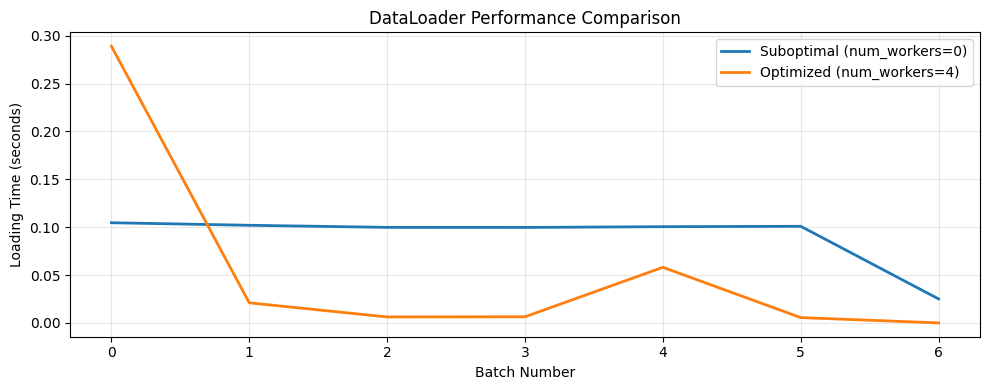

In [ ]:
print("="*60)
print("DEBUGGING & PROFILING: Find Your Bottlenecks")
print("="*60)

class DataPipelineProfiler:
    """Profiler for data loading pipelines"""
    
    def __init__(self):
        self.metrics = {
            'load_times': [],
            'batch_times': [],
            'gpu_wait_times': [],
            'memory_usage': []
        }
    
    def profile_dataloader(self, dataloader, num_batches=10):
        """Profile a DataLoader"""
        print(f"\nProfiling DataLoader with {num_batches} batches...")
        
        start_time = time.time()
        
        for batch_idx, batch in enumerate(dataloader):
            batch_time = time.time() - start_time
            self.metrics['batch_times'].append(batch_time)
            
            # Measure memory usage
            memory_mb = psutil.Process().memory_info().rss / 1024 / 1024
            self.metrics['memory_usage'].append(memory_mb)
            
            # Reset timer for next batch
            start_time = time.time()
            
            if batch_idx >= num_batches - 1:
                break
        
        self.print_report()
    
    def print_report(self):
        """Print profiling report"""
        if not self.metrics['batch_times']:
            print("No data collected")
            return
        
        batch_times = self.metrics['batch_times']
        memory_usage = self.metrics['memory_usage']
        
        print("\n📊 PROFILING REPORT:")
        print("="*40)
        print(f"Average batch time: {np.mean(batch_times)*1000:.1f} ms")
        print(f"Std batch time: {np.std(batch_times)*1000:.1f} ms")
        print(f"Min batch time: {np.min(batch_times)*1000:.1f} ms")
        print(f"Max batch time: {np.max(batch_times)*1000:.1f} ms")
        print(f"\nPeak memory usage: {np.max(memory_usage):.1f} MB")
        print(f"Average memory usage: {np.mean(memory_usage):.1f} MB")
        
        # Diagnose bottlenecks
        avg_batch_time = np.mean(batch_times)
        if avg_batch_time > 0.1:  # More than 100ms per batch
            print("\n⚠️  BOTTLENECK DETECTED: Slow data loading")
            print("   Possible causes:")
            print("   • Disk I/O too slow")
            print("   • Data augmentation too heavy")
            print("   • num_workers too low")
        
        if np.std(batch_times) > avg_batch_time * 0.5:
            print("\n⚠️  INCONSISTENT PERFORMANCE: Variable batch times")
            print("   Possible causes:")
            print("   • Mixed file sizes")
            print("   • Network latency (cloud storage)")
    
    def plot_metrics(self):
        """Plot profiling metrics"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Batch times
        axes[0].plot(self.metrics['batch_times'])
        axes[0].set_xlabel('Batch Number')
        axes[0].set_ylabel('Time (seconds)')
        axes[0].set_title('Batch Loading Times')
        axes[0].grid(True, alpha=0.3)
        
        # Memory usage
        axes[1].plot(self.metrics['memory_usage'])
        axes[1].set_xlabel('Batch Number')
        axes[1].set_ylabel('Memory (MB)')
        axes[1].set_title('Memory Usage')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Create a test dataset
class TestDataset(Dataset):
    def __init__(self, num_samples=100, delay=0.01):
        self.num_samples = num_samples
        self.delay = delay
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        time.sleep(self.delay)  # Simulate I/O delay
        return torch.randn(3, 224, 224), torch.randint(0, 10, (1,)).item()

# Test with different configurations
print("\nProfiling different DataLoader configurations:")

test_dataset = TestDataset(num_samples=100, delay=0.005)

# Configuration 1: Suboptimal
print("\n1. Suboptimal configuration (num_workers=0):")
dataloader_slow = DataLoader(test_dataset, batch_size=16, num_workers=0)
profiler1 = DataPipelineProfiler()
profiler1.profile_dataloader(dataloader_slow, num_batches=20)

# Configuration 2: Optimized
print("\n\n2. Optimized configuration (num_workers=4):")
dataloader_fast = DataLoader(
    test_dataset,
    batch_size=16,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2
)
profiler2 = DataPipelineProfiler()
profiler2.profile_dataloader(dataloader_fast, num_batches=20)

print("\n" + "="*60)
print("PROFILING INSIGHTS:")
print("="*60)
print("1. Use num_workers > 0 for parallel loading")
print("2. Monitor batch times for consistency")
print("3. Watch memory usage for leaks")
print("4. Profile regularly as dataset grows")

# Plot the comparison
fig, ax = plt.subplots(figsize=(10, 4))
batch_numbers = range(len(profiler1.metrics['batch_times']))
ax.plot(batch_numbers, profiler1.metrics['batch_times'], 
        label='Suboptimal (num_workers=0)', linewidth=2)
ax.plot(batch_numbers, profiler2.metrics['batch_times'], 
        label='Optimized (num_workers=4)', linewidth=2)
ax.set_xlabel('Batch Number')
ax.set_ylabel('Loading Time (seconds)')
ax.set_title('DataLoader Performance Comparison')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# PART 9: Real-World Project - Sudanese Agricultural Monitoring

Let's apply everything we've learned to a comprehensive real-world project. We'll build an end-to-end pipeline for Sudanese agricultural monitoring that combines multiple data sources and demonstrates practical application of our techniques.

## 🌾 End-to-End Pipeline for Crop Health Analysis

This pipeline simulates a real agricultural monitoring system combining satellite imagery, ground sensor data, and crop information - a common scenario in precision agriculture applications.

REAL-WORLD PROJECT: Sudanese Agricultural Monitoring

Testing Sudanese Agricultural Dataset:

🌾 Sudanese Agricultural Dataset - Gezira 2023
Mode: train
Samples: 1000
Satellite features: 4
Ground features: 4
Crop types: 4

📊 DATASET ANALYSIS:
Average yield: 2.40 tons/hectare
Yield range: 2.10 - 2.79 tons/hectare

Crop distribution:
  sorghum   :  25 samples (25.0%)
  millet    :  25 samples (25.0%)
  wheat     :  25 samples (25.0%)
  cotton    :  25 samples (25.0%)

Sample data structure:
  satellite      : torch.Size([12, 4])
  ground         : torch.Size([90, 4])
  crop_type      : torch.Size([4])
  metadata       : torch.Size([2])
  yield          : torch.Size([1])
  crop_name      : sorghum

Testing batched loading:
Batch size: 8
Satellite data shape: torch.Size([8, 12, 4])
Ground data shape: torch.Size([8, 90, 4])
Yields: [2.36745285987854, 2.3011252880096436, 2.790764093399048, 2.6170318126678467, 2.6046700477600098, 2.451406478881836, 2.3427484035491943, 2.5871872901916504]
Crops

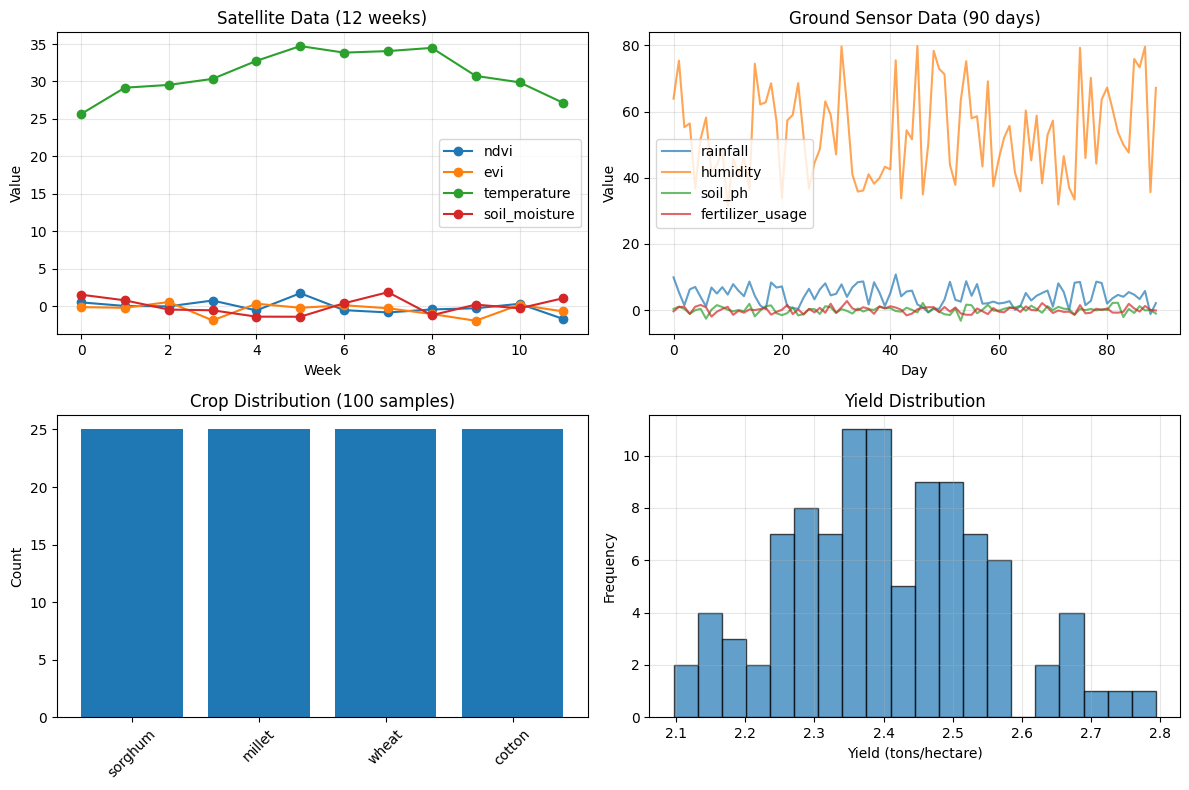


🎯 This pipeline can be used for:
• Predicting crop yields
• Identifying optimal planting times
• Detecting crop stress early
• Optimizing resource allocation


In [ ]:
print("="*60)
print("REAL-WORLD PROJECT: Sudanese Agricultural Monitoring")
print("="*60)

class SudaneseAgricultureDataset(Dataset):
    """Complete dataset for Sudanese agricultural monitoring"""
    
    def __init__(self, data_dir, region='Gezira', year=2023, mode='train'):
        """
        Simulated dataset combining:
        1. Satellite imagery (NDVI, temperature)
        2. Ground sensor data (soil moisture, rainfall)
        3. Crop labels (sorghum, millet, wheat)
        4. Yield predictions
        """
        self.data_dir = Path(data_dir)
        self.region = region
        self.year = year
        self.mode = mode
        
        # In reality, you would load from actual files
        # For demonstration, we'll create simulated data
        self.num_samples = 1000 if mode == 'train' else 200
        
        # Simulate different data sources
        self.satellite_features = ['ndvi', 'evi', 'temperature', 'soil_moisture']
        self.ground_features = ['rainfall', 'humidity', 'soil_ph', 'fertilizer_usage']
        self.crop_types = ['sorghum', 'millet', 'wheat', 'cotton']
        
        print(f"\n🌾 Sudanese Agricultural Dataset - {region} {year}")
        print(f"Mode: {mode}")
        print(f"Samples: {self.num_samples}")
        print(f"Satellite features: {len(self.satellite_features)}")
        print(f"Ground features: {len(self.ground_features)}")
        print(f"Crop types: {len(self.crop_types)}")
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        """Return multi-source agricultural data"""
        # Set random seed for reproducibility
        np.random.seed(42 + idx)
        
        # 1. Simulate satellite data (weekly observations for 3 months)
        # 12 weeks × 4 features
        satellite_data = np.random.randn(12, len(self.satellite_features)).astype(np.float32)
        
        # Add seasonal patterns
        for i in range(12):
            # NDVI increases then decreases (growing season)
            satellite_data[i, 0] += np.sin(i * np.pi / 6) * 0.5
            # Temperature pattern
            satellite_data[i, 2] += 25 + 10 * np.sin(i * np.pi / 12)
        
        # 2. Simulate ground sensor data (daily for 3 months)
        # 90 days × 4 features
        ground_data = np.random.randn(90, len(self.ground_features)).astype(np.float32)
        
        # Add realistic patterns
        ground_data[:, 0] += np.random.uniform(0, 10, 90)  # Rainfall
        ground_data[:, 1] += np.random.uniform(30, 80, 90)  # Humidity
        
        # 3. Crop type (one-hot encoded)
        crop_idx = idx % len(self.crop_types)
        crop_onehot = np.zeros(len(self.crop_types), dtype=np.float32)
        crop_onehot[crop_idx] = 1.0
        
        # 4. Target: Yield in tons/hectare
        # Base yield + positive effect of good conditions - negative effects
        base_yield = 2.0  # tons/hectare
        ndvi_effect = np.mean(satellite_data[:, 0]) * 0.5  # Better vegetation = higher yield
        rainfall_effect = np.mean(ground_data[:, 0]) * 0.1  # More rain = higher yield (to a point)
        temperature_effect = -abs(np.mean(satellite_data[:, 2]) - 30) * 0.05  # Optimal ~30°C
        
        yield_value = base_yield + ndvi_effect + rainfall_effect + temperature_effect
        yield_value = max(0.5, min(5.0, yield_value))  # Clip to realistic range
        
        # 5. Additional metadata
        farm_size = np.random.uniform(1, 10)  # hectares
        irrigation = np.random.choice([0, 1])  # 0=rainfed, 1=irrigated
        
        # Convert to tensors
        satellite_tensor = torch.tensor(satellite_data)
        ground_tensor = torch.tensor(ground_data)
        crop_tensor = torch.tensor(crop_onehot)
        metadata_tensor = torch.tensor([farm_size, irrigation], dtype=torch.float32)
        yield_tensor = torch.tensor([yield_value], dtype=torch.float32)
        
        return {
            'satellite': satellite_tensor,  # Shape: [12, 4]
            'ground': ground_tensor,       # Shape: [90, 4]
            'crop_type': crop_tensor,      # Shape: [4]
            'metadata': metadata_tensor,   # Shape: [2]
            'yield': yield_tensor,         # Shape: [1]
            'crop_name': self.crop_types[crop_idx]
        }
    
    def analyze_dataset(self):
        """Analyze and print dataset statistics"""
        print("\n📊 DATASET ANALYSIS:")
        print("="*40)
        
        # Collect statistics from first 100 samples
        yields = []
        crop_counts = {crop: 0 for crop in self.crop_types}
        
        for i in range(min(100, len(self))):
            sample = self[i]
            yields.append(sample['yield'].item())
            crop_idx = torch.argmax(sample['crop_type']).item()
            crop_counts[self.crop_types[crop_idx]] += 1
        
        print(f"Average yield: {np.mean(yields):.2f} tons/hectare")
        print(f"Yield range: {np.min(yields):.2f} - {np.max(yields):.2f} tons/hectare")
        print("\nCrop distribution:")
        for crop, count in crop_counts.items():
            percentage = (count / sum(crop_counts.values())) * 100
            print(f"  {crop:10s}: {count:3d} samples ({percentage:.1f}%)")

# Test the agricultural dataset
print("\nTesting Sudanese Agricultural Dataset:")

ag_dataset = SudaneseAgricultureDataset(
    data_dir="./data/agriculture",
    region="Gezira",
    year=2023,
    mode='train'
)

# Analyze dataset
ag_dataset.analyze_dataset()

# Look at a sample
print("\nSample data structure:")
sample = ag_dataset[0]
for key, value in sample.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key:15s}: {value.shape}")
    else:
        print(f"  {key:15s}: {value}")

# Custom collate for agricultural data
def collate_agriculture(batch):
    """Collate function for agricultural data"""
    collated = {}
    
    # Stack tensor fields
    for key in ['satellite', 'ground', 'crop_type', 'metadata', 'yield']:
        collated[key] = torch.stack([item[key] for item in batch])
    
    # Keep crop names as list
    collated['crop_names'] = [item['crop_name'] for item in batch]
    
    return collated

# Create DataLoader
ag_loader = DataLoader(
    ag_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_agriculture
)

print("\nTesting batched loading:")
for batch in ag_loader:
    print(f"Batch size: {len(batch['crop_names'])}")
    print(f"Satellite data shape: {batch['satellite'].shape}")
    print(f"Ground data shape: {batch['ground'].shape}")
    print(f"Yields: {batch['yield'].flatten().tolist()}")
    print(f"Crops: {batch['crop_names'][:3]}...")
    break

# Visualize sample data
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot satellite data for one sample
satellite_sample = sample['satellite'].numpy()
for i, feature in enumerate(ag_dataset.satellite_features):
    axes[0, 0].plot(satellite_sample[:, i], label=feature, marker='o')
axes[0, 0].set_title('Satellite Data (12 weeks)')
axes[0, 0].set_xlabel('Week')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot ground data
ground_sample = sample['ground'].numpy()
for i, feature in enumerate(ag_dataset.ground_features):
    axes[0, 1].plot(ground_sample[:, i], label=feature, alpha=0.7)
axes[0, 1].set_title('Ground Sensor Data (90 days)')
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Crop distribution
crop_counts = {crop: 0 for crop in ag_dataset.crop_types}
for i in range(100):
    sample = ag_dataset[i]
    crop_counts[sample['crop_name']] += 1

axes[1, 0].bar(crop_counts.keys(), crop_counts.values())
axes[1, 0].set_title('Crop Distribution (100 samples)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Yield histogram
yields = []
for i in range(100):
    yields.append(ag_dataset[i]['yield'].item())

axes[1, 1].hist(yields, bins=20, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Yield Distribution')
axes[1, 1].set_xlabel('Yield (tons/hectare)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 This pipeline can be used for:")
print("• Predicting crop yields")
print("• Identifying optimal planting times")
print("• Detecting crop stress early")
print("• Optimizing resource allocation")

# PART 10: Summary & Best Practices

We've covered a comprehensive range of data pipeline techniques. Let's consolidate our learning with key takeaways, templates, and best practices for production systems.

## 📚 Key Takeaways

Here's what you should remember from this lecture:

In [ ]:
print("="*60)
print("PYTORCH DATA PIPELINES - KEY TAKEAWAYS")
print("="*60)

takeaways = """
🎯 1. Dataset Design Patterns:
    • Small data → Load in __init__
    • Large data → Load in __getitem__
    • Massive data → Streaming/IterableDataset

🎯 2. DataLoader Optimization:
    • num_workers: 2-4 × CPU cores
    • pin_memory: True for GPU training
    • prefetch_factor: 2 for smooth loading
    • persistent_workers: True for faster epoch transitions

🎯 3. Sudanese-Specific Considerations:
    • Handle Arabic text encoding
    • Optimize for limited bandwidth
    • Use memory-efficient formats
    • Plan for intermittent connectivity

🎯 4. Production Best Practices:
    • Always handle corrupted files gracefully
    • Use caching for frequently accessed data
    • Profile and monitor loading performance
    • Version your data pipelines
"""
print(takeaways)

PYTORCH DATA PIPELINES - KEY TAKEAWAYS

🎯 1. Dataset Design Patterns:
    • Small data → Load in __init__
    • Large data → Load in __getitem__
    • Massive data → Streaming/IterableDataset

🎯 2. DataLoader Optimization:
    • num_workers: 2-4 × CPU cores
    • pin_memory: True for GPU training
    • prefetch_factor: 2 for smooth loading
    • persistent_workers: True for faster epoch transitions

🎯 3. Sudanese-Specific Considerations:
    • Handle Arabic text encoding
    • Optimize for limited bandwidth
    • Use memory-efficient formats
    • Plan for intermittent connectivity

🎯 4. Production Best Practices:
    • Always handle corrupted files gracefully
    • Use caching for frequently accessed data
    • Profile and monitor loading performance
    • Version your data pipelines



## 🧪 The Minimal Production-Ready Dataset

Here's a template you can use as a starting point for any production dataset. It includes error handling, caching, and proper structure.

In [ ]:
print("\n" + "="*60)
print("MINIMAL PRODUCTION DATASET TEMPLATE")
print("="*60)

minimal_template = '''
# Production Dataset Template
class ProductionDataset(Dataset):
    def __init__(self, data_path, transform=None):
        super().__init__()
        
        # 1. Load metadata (not data!)
        self.data_path = Path(data_path)
        self.samples = self._load_metadata()
        
        # 2. Set up transformations
        self.transform = transform or self._default_transform()
        
        # 3. Initialize cache (if needed)
        self.cache = {}
        
        print(f"Loaded {len(self)} samples")
    
    def _load_metadata(self):
        """Load file paths and labels"""
        samples = []
        # Your metadata loading logic here
        return samples
    
    def _default_transform(self):
        """Default data transformations"""
        return None  # Your default transforms here
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        # Check cache first
        if idx in self.cache:
            return self.cache[idx]
        
        try:
            # Load data
            data = self._load_sample(idx)
            
            # Apply transformations
            if self.transform:
                data = self.transform(data)
            
            # Cache if appropriate
            if len(self.cache) < 1000:  # Limit cache size
                self.cache[idx] = data
            
            return data
            
        except Exception as e:
            # Handle errors gracefully
            print(f"Error loading sample {idx}: {e}")
            return self._get_placeholder()  # Return placeholder
    
    def _load_sample(self, idx):
        """Load actual data for one sample"""
        # Your data loading logic here
        pass
    
    def _get_placeholder(self):
        """Return placeholder for corrupted data"""
        # Your placeholder logic here
        pass
'''
print(minimal_template)


MINIMAL PRODUCTION DATASET TEMPLATE

# Production Dataset Template
class ProductionDataset(Dataset):
    def __init__(self, data_path, transform=None):
        super().__init__()

        # 1. Load metadata (not data!)
        self.data_path = Path(data_path)
        self.samples = self._load_metadata()

        # 2. Set up transformations
        self.transform = transform or self._default_transform()

        # 3. Initialize cache (if needed)
        self.cache = {}

        print(f"Loaded {len(self)} samples")

    def _load_metadata(self):
        """Load file paths and labels"""
        samples = []
        # Your metadata loading logic here
        return samples

    def _default_transform(self):
        """Default data transformations"""
        return None  # Your default transforms here

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Check cache first
        if idx in self.cache:
            return self.cache[idx]

       

## ✍️ Exercises

Test your understanding with these exercises:

### Exercise 1: Fix the Bottleneck
This DataLoader has a performance issue. Identify and fix it:
```python
# Current implementation
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,  # Problem here
    pin_memory=False
)
```

### Exercise 2: Handle Large Images
Create a Dataset class that can handle 10,000×10,000 satellite images without loading them entirely into memory.

### Exercise 3: Arabic Text Preprocessing
Extend the ArabicTextDataset to:
1. Handle right-to-left text
2. Remove diacritics if present
3. Normalize Arabic characters

### Exercise 4: Data Pipeline for Sudanese Healthcare
Design a dataset for medical imaging in Sudanese hospitals that:
1. Handles DICOM files (medical images)
2. Includes patient metadata
3. Respects patient privacy
4. Works with limited internet connectivity

## ✅ Mastery Checklist

Before moving to the next lecture, ensure you can do all of the following:

- [ ] Create custom Dataset classes for tabular, image, and text data
- [ ] Optimize DataLoader parameters for maximum performance
- [ ] Implement data augmentation pipelines
- [ ] Handle large datasets with memory mapping
- [ ] Build multi-modal datasets (images + text)
- [ ] Create streaming datasets for cloud storage
- [ ] Profile and debug data loading bottlenecks
- [ ] Handle Arabic text encoding and preprocessing
- [ ] Implement error handling for corrupted data
- [ ] Design datasets for Sudanese-specific applications

If you can check all these boxes, you have mastered professional data pipelines with PyTorch!

## 📚 Practice & Reflection

### 🔍 **Conceptual Questions**

1. **What's the difference between `Dataset` and `IterableDataset`?**
   - When would you use each?
   - What are the performance implications?

2. **How does `num_workers` affect performance?**
   - What happens if you set it too high?
   - What's the optimal value for your machine?

3. **Why is `pin_memory` important for GPU training?**
   - What does it actually do?
   - When should you not use it?

4. **How do you handle datasets that don't fit in memory?**
   - What techniques can you use?
   - How does this affect training speed?

### 🎯 **Sudanese Context Questions**

1. **How would you design a data pipeline for:**
   - Sudanese dialect Arabic speech recognition?
   - Crop disease detection from mobile phone photos?
   - Market price prediction from SMS messages?

2. **What special considerations are needed for:**
   - Limited internet connectivity?
   - Power outages during training?
   - Multi-format data (SMS, WhatsApp, photos)?

<div align="center">
  
### **🌟 Building Sudan's AI Future, One Dataset at a Time**

*"Good data pipelines don't just load data—they enable research, empower communities, and build resilient AI systems."*

🇸🇩 **SAIR Community - Sudanese Artificial Intelligence Research**

</div>